# Test My Convolutional NetWork

Test my convnet.py like official doing.

In [5]:
# as usual, a bit of set up

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.classifiers.convnet import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
    print '%s ' % k, v.shape

X_val  (1000, 3, 32, 32)
X_train  (49000, 3, 32, 32)
X_test  (1000, 3, 32, 32)
y_val  (1000,)
y_train  (49000,)
y_test  (1000,)


# Convolutional "sandwich" conv_bn_relu layers
gradient check for conv_bn_relu convenience layer

In [56]:
from cs231n.layer_utils import conv_bn_relu_forward, conv_bn_relu_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.zeros(3,)
dout = np.random.randn(2, 3, 16, 16)
conv_param = {'stride': 1, 'pad': 1}
bn_param = {'mode': 'train'}
gamma = np.random.randn(3)
beta = np.random.randn(3)

out, cache = conv_bn_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)
dx, dw, db, dgamma, dbeta = conv_bn_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(
    lambda x: conv_bn_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(
    lambda w: conv_bn_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], w, dout)
db_num = eval_numerical_gradient_array(
    lambda b: conv_bn_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], b, dout)
dgamma_num = eval_numerical_gradient_array(
    lambda gamma: conv_bn_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], gamma, dout)
dbeta_num = eval_numerical_gradient_array(
    lambda beta: conv_bn_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], beta, dout)

print 'Testing conv_bn_relu'
print 'dx error: ', rel_error(dx, dx_num)
print 'dw error: ', rel_error(dw, dw_num)
print 'db error: ', rel_error(db, db_num)
print 'dgamma error: ', rel_error(dgamma, dgamma_num)
print 'dbeta error: ', rel_error(dbeta, dbeta_num)


Testing conv_bn_relu
dx error:  5.25596854489e-07
dw error:  4.66171360942e-08
db error:  0.0117220466107
dgamma error:  8.22762532292e-13
dbeta error:  4.60941124899e-12


In [57]:
# gradient check for convenience conv_bn_relu_pool layer

from cs231n.layer_utils import conv_bn_relu_pool_forward, conv_bn_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.zeros(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
bn_param = {'mode': 'train'}
pool_param = {'pool_height': 2,
              'pool_width': 2,
              'stride': 2
              }

gamma = np.random.randn(3)
beta = np.random.randn(3)

out, cache = conv_bn_relu_pool_forward(x, w, b, conv_param, gamma, beta, bn_param, pool_param)
dx, dw, db, dgamma, dbeta = conv_bn_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(
    lambda x: conv_bn_relu_pool_forward(x, w, b, conv_param, gamma, beta, bn_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(
    lambda w: conv_bn_relu_pool_forward(x, w, b, conv_param, gamma, beta, bn_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(
    lambda b: conv_bn_relu_pool_forward(x, w, b, conv_param, gamma, beta, bn_param, pool_param)[0], b, dout)
dgamma_num = eval_numerical_gradient_array(
    lambda gamma: conv_bn_relu_pool_forward(x, w, b, conv_param, gamma, beta, bn_param, pool_param)[0], gamma, dout)
dbeta_num = eval_numerical_gradient_array(
    lambda beta: conv_bn_relu_pool_forward(x, w, b, conv_param, gamma, beta, bn_param, pool_param)[0], beta, dout)

print 'Testing conv_bn_relu_pool'
print 'dx error: ', rel_error(dx, dx_num)
print 'dw error: ', rel_error(dw, dw_num)
print 'db error: ', rel_error(db, db_num)
print 'dgamma error: ', rel_error(dgamma, dgamma_num)
print 'dbeta error: ', rel_error(dbeta, dbeta_num)

Testing conv_bn_relu_pool
dx error:  1.36602898509e-06
dw error:  3.97459466099e-09
db error:  0.00542535053123
dgamma error:  3.94909714153e-12
dbeta error:  3.8354556868e-12


In [78]:
from cs231n.classifiers.convnet import MyConvNet
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = MyConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

Use batchnorm!!
W1 max relative error: 2.057915e-06
W2 max relative error: 2.823849e-07
W3 max relative error: 1.940245e-05
W4 max relative error: 5.565739e-08
W5 max relative error: 6.290186e-06
b1 max relative error: 5.421011e-10
b2 max relative error: 7.214603e-10
b3 max relative error: 0.000000e+00
b4 max relative error: 0.000000e+00
b5 max relative error: 5.548462e-10
beta1 max relative error: 8.169429e-05
beta2 max relative error: 2.748748e-05
beta3 max relative error: 5.217096e-06
beta4 max relative error: 2.406920e-07
gamma1 max relative error: 9.126638e-06
gamma2 max relative error: 4.766590e-05
gamma3 max relative error: 3.177679e-04
gamma4 max relative error: 1.686109e-03


# Test MyConvNet in small data

In [81]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = MyConvNet(weight_scale=5e-4)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 5e-3,
                },
                verbose=True, print_every=1)
solver.train()

Use batchnorm!!
(Iteration 1 / 30) loss: 2.302039
(Epoch 0 / 15) train acc: 0.140000; val_acc: 0.138000
(Iteration 2 / 30) loss: 2.293830
(Epoch 1 / 15) train acc: 0.190000; val_acc: 0.149000
(Iteration 3 / 30) loss: 2.150840
(Iteration 4 / 30) loss: 1.974861
(Epoch 2 / 15) train acc: 0.390000; val_acc: 0.181000
(Iteration 5 / 30) loss: 1.955078
(Iteration 6 / 30) loss: 2.008504
(Epoch 3 / 15) train acc: 0.480000; val_acc: 0.223000
(Iteration 7 / 30) loss: 1.728551
(Iteration 8 / 30) loss: 1.278840
(Epoch 4 / 15) train acc: 0.550000; val_acc: 0.223000
(Iteration 9 / 30) loss: 1.516357
(Iteration 10 / 30) loss: 1.237861
(Epoch 5 / 15) train acc: 0.670000; val_acc: 0.227000
(Iteration 11 / 30) loss: 0.946770
(Iteration 12 / 30) loss: 0.951139
(Epoch 6 / 15) train acc: 0.710000; val_acc: 0.225000
(Iteration 13 / 30) loss: 1.104809
(Iteration 14 / 30) loss: 0.669280
(Epoch 7 / 15) train acc: 0.710000; val_acc: 0.222000
(Iteration 15 / 30) loss: 0.692709
(Iteration 16 / 30) loss: 0.871941
(

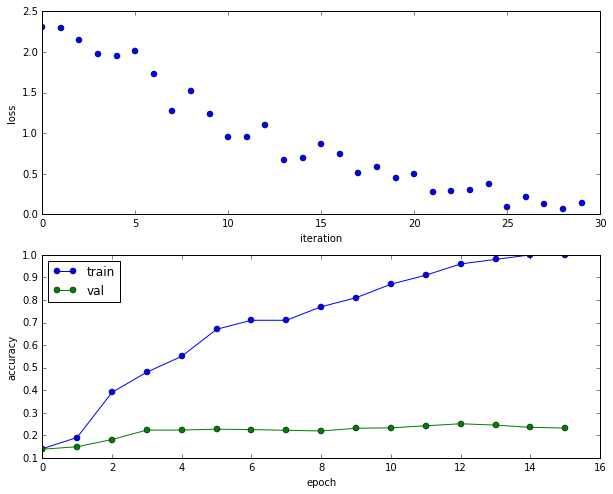

In [82]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Train My Net

In [ ]:
model = MyConvNet(weight_scale=5e-4, hidden_dim=300, reg=5e-3,
                  num_filters=32, filter_size=5)

solver = Solver(model, data,
                num_epochs=8, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-4,
                },
                verbose=True, print_every=20)
solver.train()

Use batchnorm!!
(Iteration 1 / 7840) loss: 2.303459
(Epoch 0 / 8) train acc: 0.121000; val_acc: 0.123000
(Iteration 21 / 7840) loss: 2.045614
(Iteration 41 / 7840) loss: 2.017497
(Iteration 61 / 7840) loss: 1.770245
(Iteration 81 / 7840) loss: 1.781921
(Iteration 101 / 7840) loss: 1.519064
(Iteration 121 / 7840) loss: 1.593261
(Iteration 141 / 7840) loss: 1.482478

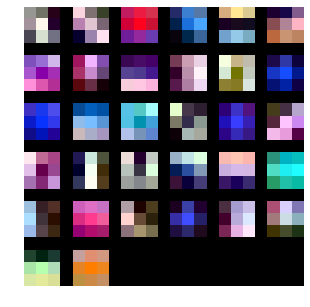

In [85]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()